In [1]:
%matplotlib inline

import matplotlib.pyplot as plt

import healpy as hp

import numpy as np

import tensorflow as tf

from deepsphere import HealpyGCNN
from deepsphere import healpy_layers as hp_layer

### Quick Start

This notebook gives a quick introduction into deepsphere for TF 2.x

We use the same data as in the original [DeepSphere repo](https://github.com/SwissDataScienceCenter/DeepSphere).

### 1 Data loading

The data consists of a toy dataset that is sufficiently small to have fun with. It is made of 200 maps of size `NSIDE=64` splitted into 2 classes. 

The maps contain a Gaussian random field realisations produced with Synfast function from Healpy package.
The input power spectra were taken from LambdaCDM model with two sets of parameters.
These maps are not realistic cosmological mass maps, just a toy dataset.
We downsampled them to `Nside=64` in order to make the processing faster.

In [2]:
data = np.load('../data/maps_downsampled_64.npz')
assert(len(data['class1']) == len(data['class2']))
nclass = len(data['class1'])

Let us plot a map of each class. It is not simple to visually catch the differences.

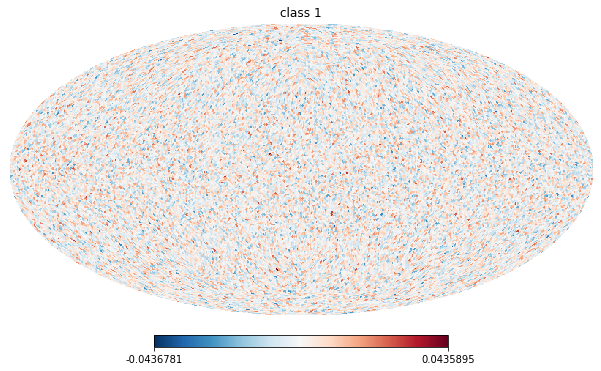

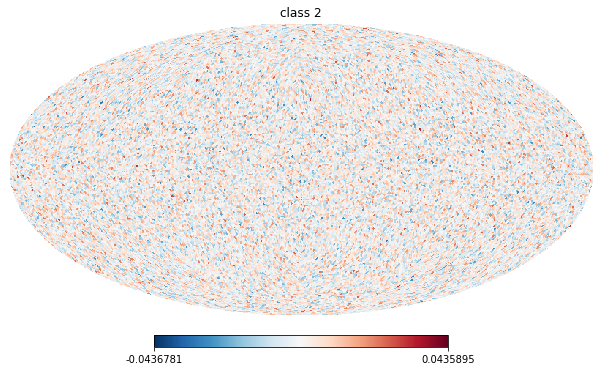

In [3]:
cmin = min(np.min(data['class1']), np.min(data['class2']))
cmax = max(np.max(data['class1']), np.max(data['class2']))
cm = plt.cm.RdBu_r
hp.mollview(data['class1'][0], title='class 1', nest=True, cmap=cm, min=cmin, max=cmax)
hp.mollview(data['class2'][0], title='class 2', nest=True, cmap=cm, min=cmin, max=cmax)

### 2 Classification using DeepSphere

Here we will define a network and train it such that it can correctly classifiy the two classes of maps. We start by defining the layers we want to use. The `HealpyGCNN` class is a subclass from `tf.keras.Sequential`, meaning we can use a lot of the already existing TF functionality and can even interlace normal layers with our graph convolution if we want to.

In [4]:
layers = [hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=5, use_bias=True, use_bn=True, 
                                   activation="relu"),
          hp_layer.HealpyPool(p=1),
          hp_layer.HealpyChebyshev(K=10, Fout=2),
          tf.keras.layers.Lambda(lambda x: tf.nn.softmax(tf.reduce_mean(x, axis=1),
                                                         axis=-1))]

Now we degine the nside and the relevant pixels.

In [5]:
nside = 64
indices = np.arange(hp.nside2npix(nside))

We build the network with an input shape and print out a summary.

In [6]:
tf.keras.backend.clear_session()
model = HealpyGCNN(nside=nside, indices=indices, layers=layers)
batch_size = 16
model.build(input_shape=(None, len(indices), 1))
model.summary(110)

Detected a reduction factor of 8.0, the input with nside 64 will be transformed to 8 during a forward pass. Checking for consistency with indices...
indices seem consistent...
Model: "healpy_gcnn_1"
______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
chebyshev (Chebyshev)                            (None, 49152, 5)                            65               
______________________________________________________________________________________________________________
healpy_pool (HealpyPool)                         (None, 12288, 5)                            0                
______________________________________________________________________________________________________________
chebyshev_1 (Chebyshev)                          (None, 12288, 5)                            265              
________________________

We create a dataset for training with a channel dimension and labels

In [7]:
x_raw = np.concatenate([data["class1"], data["class2"]]).astype(np.float32)[...,None]
y_raw = np.concatenate([np.zeros(nclass), np.ones(nclass)]).astype(np.float32)

np.random.seed(11)
np.random.shuffle(x_raw)
np.random.seed(11)
np.random.shuffle(y_raw)

x_train, x_test = np.split(x_raw, indices_or_sections=[150])
y_train, y_test = np.split(y_raw, indices_or_sections=[150])

We compile the model

In [8]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.1),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)

In [9]:
print("Fit model on training data")
history = model.fit(
    x=x_train,
    y=y_train,
    batch_size=batch_size,
    epochs=12,
    validation_data=(x_test, y_test),
)

Fit model on training data
Epoch 1/12
10/10 [==============================] - 4s 438ms/step - loss: 1.4786 - sparse_categorical_accuracy: 0.6533 - val_loss: 6.4485 - val_sparse_categorical_accuracy: 0.4600
Epoch 2/12
10/10 [==============================] - 4s 382ms/step - loss: 0.0068 - sparse_categorical_accuracy: 1.0000 - val_loss: 7.2975 - val_sparse_categorical_accuracy: 0.5400
Epoch 3/12
10/10 [==============================] - 5s 520ms/step - loss: 0.0097 - sparse_categorical_accuracy: 1.0000 - val_loss: 15.8144 - val_sparse_categorical_accuracy: 0.5400
Epoch 4/12
10/10 [==============================] - 4s 403ms/step - loss: 0.0011 - sparse_categorical_accuracy: 1.0000 - val_loss: 3.1549 - val_sparse_categorical_accuracy: 0.4600
Epoch 5/12
10/10 [==============================] - 4s 375ms/step - loss: 0.0013 - sparse_categorical_accuracy: 1.0000 - val_loss: 8.7301 - val_sparse_categorical_accuracy: 0.4600
Epoch 6/12
10/10 [==============================] - 4s 385ms/step - loss

A final evaluation on the test set

In [10]:
model.evaluate(x_test, y_test)

2/2 [==============================] - 0s 112ms/step - loss: 4.6623e-04 - sparse_categorical_accuracy: 1.0000


[0.000466228841105476, 1.0]

Let's plot the loss (note that the history object contains much more info...)

Text(0, 0.5, 'Loss')

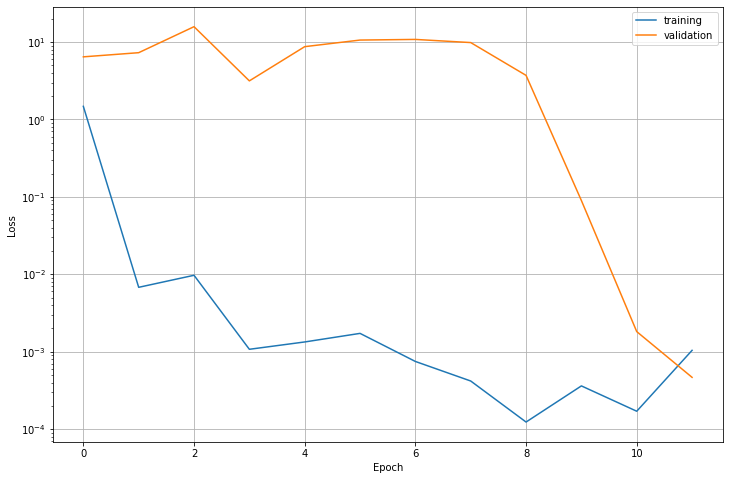

In [11]:
plt.figure(figsize=(12,8))
plt.plot(history.history["loss"], label="training")
plt.plot(history.history["val_loss"], label="validation")
plt.grid()
plt.yscale("log")
plt.legend()
plt.xlabel("Epoch")
plt.ylabel("Loss")

### 3 Filter Visualization

We observe the Chebyshef polynomial, i.e the filters in the graph spectral domain. This visuallization can help to understand wich graph frequencies are picked by the filtering operation. It mostly interpretable by the people for the graph signal processing community.

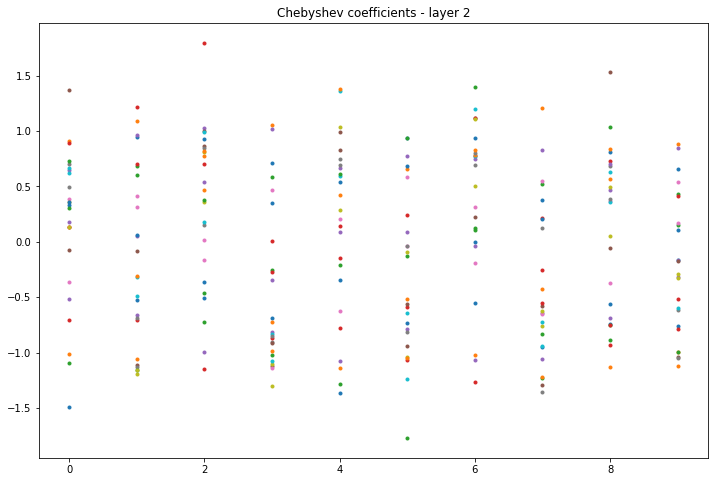

In [12]:
layer=2
plt.figure(figsize=(12,8))
model.plot_chebyshev_coeffs(layer)

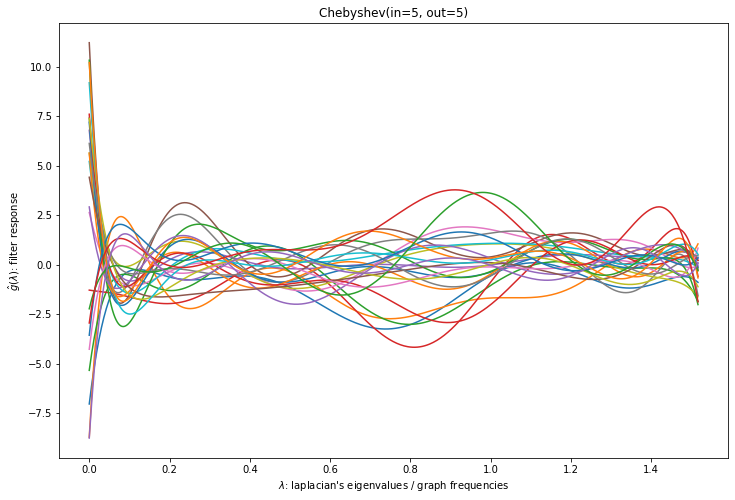

In [13]:
plt.figure(figsize=(12,8))
model.plot_filters_spectral(layer)

Here comes one of the most human friendly representation of the filters. It consists the section of the filters "projected" on the sphere. Because of the irregularity of the healpix sampling, this representation of the filters may not look very smooth.

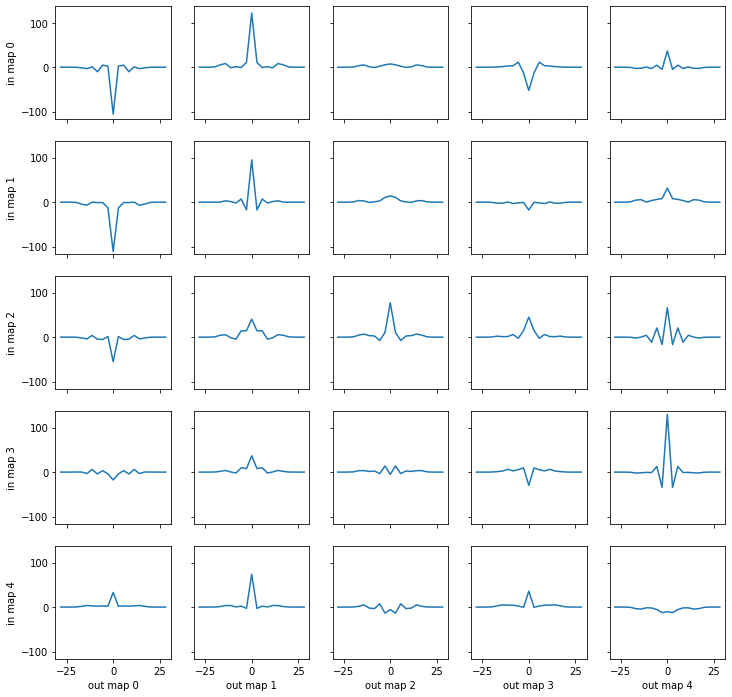

In [14]:
model.plot_filters_section(layer, title='');

Eventually, we can simply look at the filters on sphere. This representation clearly displays the sampling artifacts.

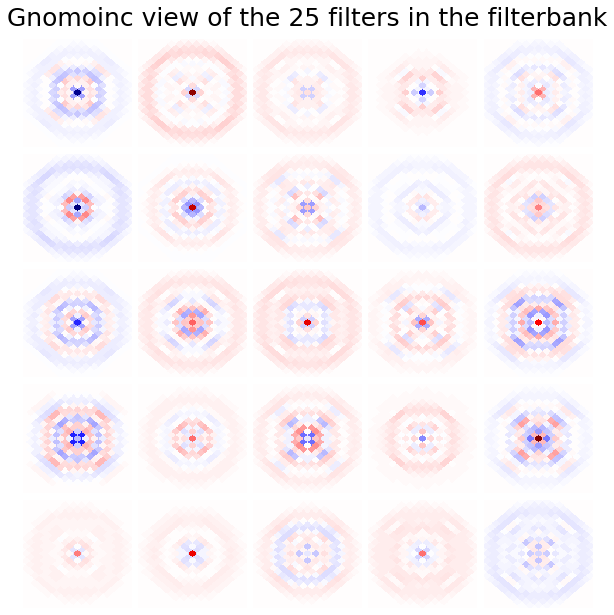

In [15]:
figs = model.plot_filters_gnomonic(layer, title=None)